# Cross Entropy
> PyTorch와 Numpy로 구현하는 Cross Entropy

- toc: true 
- badges: true
- comments: true
- categories: [Implementation, AI-math]
- image: images/chart-preview.png

# Library 호출

In [2]:
import math
import numbers
from typing import Optional, Tuple, Sequence, Union, Any

import numpy as np

import torch
import torch.nn as nn

# Numpy로 구현하기

In [24]:
class NumpyCrossEntropy:

    @staticmethod
    def log_softmax(ndarray: np.ndarray, dim: int = -1) -> np.ndarray:
        c = np.amax(ndarray, axis=dim, keepdims=True)
        s = ndarray - c
        nominator = np.exp(s)
        denominator = nominator.sum(axis=-1, keepdims=True)
        probs = nominator / denominator
        return np.log(probs)

    @staticmethod
    def negative_log_likelihood(y_pred: np.ndarray, y: np.ndarray) -> np.ndarray:
        # must to be batch_first
        log_likelihood = y_pred[np.arange(y_pred.shape[0]), y]
        nll = -log_likelihood
        return np.mean(nll)

    def cross_entropy(self, y_pred: np.ndarray, y: np.ndarray) -> np.ndarray:
        log_probs = self.log_softmax(y_pred)
        ce_loss = self.negative_log_likelihood(log_probs, y)
        return ce_loss

In [25]:
nce = NumpyCrossEntropy()

# PyTorch로 구현하기

In [131]:
_TensorOrTensors = Union[torch.Tensor, Sequence[torch.Tensor]]


class LogSoftmax(torch.autograd.Function):

    @staticmethod
    def forward(ctx: Any, tensor: Any, dim: int = -1) -> Any:
        # softmax(x) = softmax(x+c)
        c = torch.amax(tensor, dim=dim, keepdims=True)
        s = tensor - c
        # Calculate softmax
        nominator = torch.exp(s)
        denominator = nominator.sum(dim=dim, keepdims=True)
        probs = nominator / denominator
        # Calculate log
        log_probs = torch.log(probs)
        ctx.save_for_backward(probs, torch.tensor(dim))
        return log_probs

    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/SoftMax.cpp#L219
        probs, dim, = ctx.saved_tensors
        grad_outputs -= probs * grad_outputs.sum(dim=dim.item(), keepdims=True)
        return grad_outputs, None


class NegativeLogLikelihoodLoss(torch.autograd.Function):

    @staticmethod
    def forward(ctx: Any, y_pred: Any, y: Any) -> Any:
        bsz, n_classes = torch.tensor(y_pred.size())
        ctx.save_for_backward(bsz, n_classes, y)
        log_likelihood = y_pred[torch.arange(bsz), y] # Calculate Log Likelihood
        nll = -log_likelihood # Calculate Negative Log Likelihood
        return torch.mean(nll) # Calculate Loss

    @staticmethod
    def backward(ctx: Any, grad_outputs: Any) -> Any:
        bsz, n_classes, y, = ctx.saved_tensors
        mean_grad = grad_outputs.expand(bsz) / bsz # backward mean function
        negative_mean_grad = -mean_grad # backward negative
        # backward log likelihood (indexing)
        ll_grad = torch.zeros(bsz, n_classes)
        ll_grad[torch.arange(bsz), y] = 1.
        grad_outputs = torch.diag(negative_mean_grad) @ ll_grad
        return grad_outputs, None


class CrossEntropyLoss(nn.Module):
    
    log_softmax = LogSoftmax.apply
    negative_log_likelihood = NegativeLogLikelihoodLoss.apply

    def forward(self, y_pred, y):
        log_probs = self.log_softmax(y_pred, -1)
        ce_loss = self.negative_log_likelihood(log_probs, y)
        probs = torch.exp(log_probs) / log_probs.size(0)
        self.save_for_backward(probs, y, y_pred.size(0), y_pred.size(-1))
        return ce_loss

    def save_for_backward(self, *args):
        self.saved_tensors = args

    @torch.no_grad()
    def backward(self, grad_outputs: _TensorOrTensors) -> _TensorOrTensors:
        probs, y, bsz, num_classes, = self.saved_tensors
        y = torch.nn.functional.one_hot(y, num_classes=num_classes)
        ce_grad = probs - (y / bsz)
        return grad_outputs * ce_grad
    
    
class PyTorchCrossEntropy:
    
    def __init__(self):
        self.cross_entropy = CrossEntropyLoss()
        self.log_softmax = self.cross_entropy.log_softmax
        self.negative_log_likelihood = self.cross_entropy.negative_log_likelihood

In [132]:
tce = PyTorchCrossEntropy()

# 결과값 비교

In [133]:
import random
from functools import partial


batch_size = 8
vocab_size = 3000

rtol = 1e-4
atol = 1e-6
isclose = partial(torch.isclose, rtol=rtol, atol=atol)

In [134]:
y_pred = [[random.normalvariate(mu=0., sigma=1.) for _ in range(vocab_size)] for _ in range(batch_size)]
y_pred_torch = torch.FloatTensor(y_pred)
y_pred_torch.requires_grad = True
y_pred_numpy = y_pred_torch.detach().numpy()

y = [random.randint(0, vocab_size) for _ in range(batch_size)]
y_torch = torch.LongTensor(y)
y_numpy = y_torch.numpy()

In [140]:
ce_result = nn.CrossEntropyLoss()(y_pred_torch, y_torch)
ce_numpy = nce.cross_entropy(y_pred_numpy, y_numpy)
ce_torch = tce.cross_entropy(y_pred_torch, y_torch)

try:
    isclose(ce_result, ce_torch).item()
    isclose(ce_result, torch.tensor(ce_numpy)).item()
    success = True
except:
    success = False

print("Do both output the same tensors?", "🔥" if success else "💩")
if not success:
    raise Exeption("Something went wrong")

Do both output the same tensors? 🔥


In [141]:
# backward (under debugging)
ce_grad = torch.autograd.grad(ce_result, y_pred_torch, retain_graph=True)[0]
my_ce_grad1 = torch.autograd.grad(ce_torch, y_pred_torch, retain_graph=True)[0]
my_ce_grad2 = tce.cross_entropy.backward(torch.ones_like(y_pred_torch))
# my_ce_grad2 = tce.cross_entropy.backward(y_pred_torch)

try:
    isclose(ce_grad, my_ce_grad1).all()
    isclose(ce_grad, my_ce_grad2).all()
    success = True
except:
    success = False

print("Do both output the same tensors?", "🔥" if success else "💩")
if not success:
    raise Exeption("Something went wrong")

Do both output the same tensors? 🔥


In [100]:
import matplotlib.pyplot as plt

In [106]:
(~isclose(ce_grad, my_ce_grad)).sum(dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1])

tensor([0, 0, 0,  ..., 0, 0, 0])

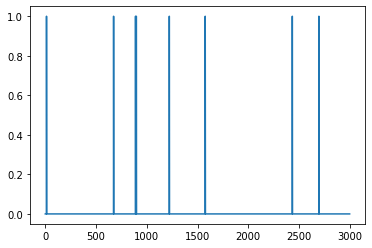

In [68]:
plt.plot((~isclose(ce_grad, my_ce_grad)).sum(dim=0).numpy())

In [58]:
(~isclose(ce_grad, my_ce_grad)[:, 1000:2000]).sum()

tensor(2)